# Simulações 
Data: 16/02/2021, Autor: Diego Ferruzzo

Simulações do modelo:
\begin{align}
\dfrac{ds}{dt}&=\mu+\gamma -\alpha(1-\theta)si-(\mu+\gamma+\omega) s -\gamma i -\gamma s_{ick}\\
\dfrac{di}{dt}&=\alpha(1-\theta)si-(\beta_1+\beta_2+\mu)i\\
\dfrac{ds_{ick}}{dt}&=\beta_2i-(\beta_3+\mu)s_{ick}
\end{align}

com os parâmetros ótimos obtidos com o *script* 'Ajuste do Índice de Isolamento.ipynb'

In [1]:
# Carregando librarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from myfunctions import rk4, modelo_vac_1
from scipy.integrate import odeint
import datetime
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual 
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D

# parâmetros para ajustar o tamanho das figuras
#plt.rcParams['figure.figsize'] = [15, 5]
#plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## Carregando dados e parâmetros
Os parâmetros obtidos estão no arquivo 'param_otim.csv'

In [2]:
parametros = pd.read_csv('param_otim.csv')
mu_otm = parametros['Valor'][0]
gamma_otm = parametros['Valor'][1]
alpha_otm = parametros['Valor'][2]
beta1_otm = parametros['Valor'][3]
beta2_otm = parametros['Valor'][4]
beta3_otm = parametros['Valor'][5]
s0_otm = parametros['Valor'][6]
i0_otm = parametros['Valor'][7]
parametros

,Parametros,Valor
0,mu,0.000020
1,gamma,0.027692
2,alpha,0.669869
3,beta1,0.142857
4,beta2,0.181884
5,beta3,0.066667
6,s0,0.999786
7,i0,0.000214


Carregando os dados das simulações obtidas na otimização

In [3]:
simulac = pd.read_csv('simula_otim.csv').to_numpy()

Carregando dados reais de casos confirmados de COVID-19 para a cidade de São Paulo

In [4]:
saopaulo_covid_df = pd.read_csv("data/SaoPaulo_dados_covid.csv")
saopaulo_covid_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
# calculo da população total da cidade de São Paulo a partir dos dados da última coluna no arquivo SaoPaulo_dados_covid.csv
saopaulo_pop_tot = int(saopaulo_covid_df['pop'].mean())
# extarir os casos confirmados
saopaulo_casos = saopaulo_covid_df['casos'].to_numpy().reshape(-1,1)
# mostrar os primeiros 5 dados do arquivo 
saopaulo_covid_df.head()

,datahora,casos,obitos,pop
0,2020-02-25,1,0,11869660
1,2020-02-26,1,0,11869660
2,2020-02-27,1,0,11869660
3,2020-02-28,2,0,11869660
4,2020-02-29,2,0,11869660


Simulação do primeiro modelo ded vacinação para a cidade de São Paulo

In [5]:
# A condição inicial é o último valor obtido na simulação anterior
s0 = simulac[-1,1]
i0 = simulac[-1,2]
sick0 = simulac[-1,3]
x0 = np.array([s0, i0, sick0])
# o tempo inicial da simulação tambémdeve ser o último valor obtido na simulação anterior
t0 = simulac[-1,0]
h = 1 # passo de integração é um dia
N = 400 # número de iterações
tf = t0 + N
# com theta igual a 
theta = 0.45
# com omega igual a
omega = 0.51
# os parâmetros:
p = np.zeros(8)
p[0] = mu_otm
p[1] = gamma_otm
p[2] = alpha_otm
p[3] = theta
p[4] = beta1_otm
p[5] = beta2_otm
p[6] = beta3_otm
p[7] = omega

#  Variar $\theta$ numa simulação só para $\omega$ fixo
Com o objetivo de visualizar a influência do distanciamento social, representado aqui por $\theta$, simulamos o modelo anterior com $\omega=0$.

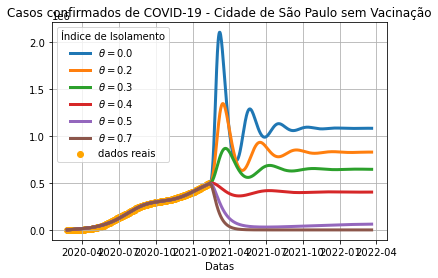

In [7]:
# os parâmetros:
omega = 0;
p = np.zeros(8)
p[0] = mu_otm
p[1] = gamma_otm
p[2] = alpha_otm
# p[3] = theta
p[4] = beta1_otm
p[5] = beta2_otm
p[6] = beta3_otm
p[7] = omega

theta_var = [0.0, 0.2, 0.3, 0.4, 0.5, 0.7]

for i in theta_var:
    p[3] = i
    t, sol =  rk4(lambda t, x: modelo_vac_1(t, x, p), x0, t0, tf, h)
    # concatenando os resultados obtidos aqui 't' e 'sol' com os dados da simulação anterior para obter a dinâmica total
    t_tot = np.concatenate((simulac[:,0],t))
    sol_tot = np.concatenate((simulac[:,1:4],sol))
    # criando um vetor de dias
    dia1 = pd.to_datetime(saopaulo_covid_df['datahora'][0], format="%Y/%m/%d")
    dias_tot = pd.date_range(dia1, periods=t_tot.size).tolist()
    dias_dados = pd.date_range(dia1, periods=simulac[:,0].size).tolist()
    # Os graficos das soluções
    plt.plot(dias_tot, sol_tot[:,2]*saopaulo_pop_tot, linewidth=3, label='$\\theta= $'+str(i))
    
plt.scatter(dias_dados, saopaulo_casos, color='orange', label='dados reais')    
plt.grid(True)
plt.title('Casos confirmados de COVID-19 - Cidade de São Paulo sem Vacinação')
plt.xlabel('Datas')
plt.legend(title='Índice de Isolamento')    
plt.show()

# Variar $\omega$ numa simulação só para $\theta$ fixo
Com o objetivo de visualizar a influência do processo de vacinação, representado aqui por $\omega$, simulamos o modelo anterior com $\theta$ fixo igual a 0,45.

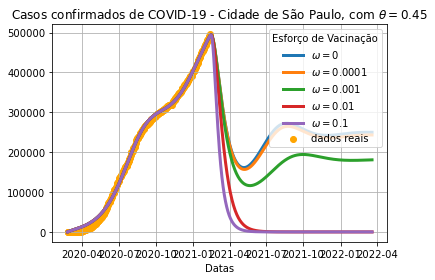

In [8]:
# os parâmetros:
theta = 0.45
p = np.zeros(8)
p[0] = mu_otm
p[1] = gamma_otm
p[2] = alpha_otm
p[3] = theta
p[4] = beta1_otm
p[5] = beta2_otm
p[6] = beta3_otm
#p[7] = omega

omega_var = [0, 1/10000, 1/1000, 1/100, 1/10]

for i in omega_var:
    p[7] = i
    t, sol =  rk4(lambda t, x: modelo_vac_1(t, x, p), x0, t0, tf, h)
    # concatenando os resultados obtidos aqui 't' e 'sol' com os dados da simulação anterior para obter a dinâmica total
    t_tot = np.concatenate((simulac[:,0],t))
    sol_tot = np.concatenate((simulac[:,1:4],sol))
    # criando um vetor de dias
    dia1 = pd.to_datetime(saopaulo_covid_df['datahora'][0], format="%Y/%m/%d")
    dias_tot = pd.date_range(dia1, periods=t_tot.size).tolist()
    dias_dados = pd.date_range(dia1, periods=simulac[:,0].size).tolist()
    # Os graficos das soluções
    plt.plot(dias_tot, sol_tot[:,2]*saopaulo_pop_tot, linewidth=3, label='$\\omega = $'+str(i))
    
plt.scatter(dias_dados, saopaulo_casos, color='orange', label='dados reais')    
plt.grid(True)
plt.title('Casos confirmados de COVID-19 - Cidade de São Paulo, com $\\theta=0.45$')
plt.xlabel('Datas')
plt.legend(title='Esforço de Vacinação')    
plt.show()

# Cálculo de $\mathcal{R}_0$
A partir da figura anterior vemos que claramente existe um valor mínimo de $\omega$ que garante o equilíbrio livre de doênça, esse valor pode ser calculado a partir de $\mathcal{R}_0$.
Temos que
\begin{align}
    \mathcal{R}_0 = \dfrac{\alpha(1-\theta)}{\beta_1+\beta_2+\mu}.
\end{align}
O equilíbrio endêmico é estável se
\begin{align}
\mathcal{R}_0 \geq &  \dfrac{\gamma +\mu +\omega}{\gamma +\mu}=f(\omega)
\end{align}
se a condição não é satisfeita então o equilibrio endêmico é instável e o equilíbrio livre de docência é estável.


In [9]:
# Definindo R0
def R0(alpha,theta,beta1,beta2,mu):
    return(alpha*(1-theta)/(beta1+beta2+mu))

# Definindo uma função para calcular omega em função de R_0, gamma e mu
def R0_inv(R_0, gamma, mu):
    return((R_0*(gamma + mu))-(gamma+mu))

R0_cal = R0(alpha_otm, theta, beta1_otm, beta2_otm, mu_otm)
print('R0 =',R0_cal)

omega_critico = R0_inv(R0(alpha_otm, theta, beta1_otm, beta2_otm, mu_otm), gamma_otm, mu_otm)
print('omega crítico =', omega_critico)

R0 = 1.1344576122091008
omega crítico = 0.003726053392432715


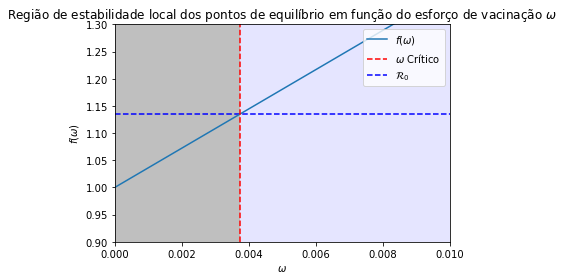

In [10]:
# Definindo a função (gamma+mu+omega)/(gamma+mu)
def equi_w(gamma, mu, omega):
    return((gamma+mu+omega)/(gamma+mu))

omega_var = np.linspace(0, 0.01, 10)

plt.plot(omega_var, equi_w(gamma_otm, mu_otm, omega_var))
plt.xlabel('$\\omega$')
plt.ylabel('$f(\omega)$')
plt.axvline(x=omega_critico, color='red', linestyle='dashed')
#matplotlib.pyplot.hlines(y, xmin, xmax, colors=None, linestyles='solid', label='', *, data=None, **kwargs)
plt.hlines(R0_cal, omega_var[0], omega_var[-1],linestyle='dashed', color='blue')
plt.fill_between([0, omega_critico], 0, equi_w(gamma_otm, mu_otm, omega_var[-1]), facecolor='gray',
                 interpolate=True, alpha=0.5)
plt.fill_between([omega_critico, omega_var[-1]], 0, equi_w(gamma_otm, mu_otm, omega_var[-1]), facecolor='blue',
                 interpolate=True, alpha=0.1)
plt.autoscale(enable=True, axis='both', tight=True)
plt.ylim(ymax = 1.3, ymin = 0.9)
plt.title('Região de estabilidade local dos pontos de equilíbrio em função do esforço de vacinação $\omega$')
plt.legend(['$f(\omega)$','$\omega$ Crítico', '$\mathcal{R}_0$'], loc=1)
plt.show()

No gráfico anterior a área sombreada representa a região de estabilidade local do equilíbrio endêmico, a área em azul representa a região de estabilidade lcoal do equilíbrio livre de doênça.

Para visualizar melhor a relação entre o índice de isolmento $\theta$ e o esforço de vacinação $\omega$ com a estabilidade local dos pontos de equilíbrio, podemos analisar a relação $g(\theta, \omega):=\dfrac{\mathcal{R}_0(\theta)}{f(\omega)}\geq1$ que deterina a região de estabilidade local do equilíbrio endêmico no espaço dos parâmetros $(\theta, \omega)$.
\begin{align}
g(\theta,\omega):=\left(\dfrac{\alpha(1-\theta)}{\beta_1+\beta_2+\mu}\right)\left(\dfrac{\gamma +\mu}{\gamma +\mu +\omega}\right)\geq 1
\end{align}

In [11]:
def g(theta, omega, alpha, beta1, beta2, gamma, mu):
    return((alpha*(1-theta)/(beta1 + beta2 + mu))*(gamma + mu)/(gamma + mu + omega))

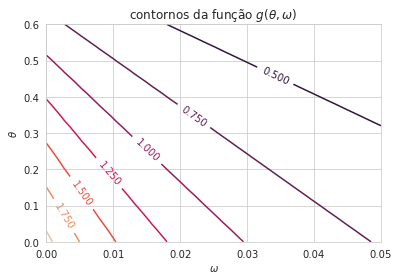

In [22]:
omega_var = np.linspace(0,0.05,20)
theta_var = np.linspace(0,0.6,20)
xv, yv = np.meshgrid(omega_var, theta_var, sparse=False, indexing='ij')
g_curve = g(yv, xv, alpha_otm, beta1_otm, beta2_otm, gamma_otm, mu_otm)
CS = plt.contour(xv, yv, g_curve, 7)
plt.clabel(CS, inline=True, fontsize=10)
plt. xlabel('$\omega$')
plt. ylabel('$\\theta$')
plt.title("contornos da função $g(\\theta, \omega)$")
plt.show()

Na figura anterior, 
- A região $g(\theta,\omega)\geq1$ (abaixo da linha $g(\theta,\omega)=1$) corresponde ao equilíbrio endêmico localmente estável.
- A região $g(\theta,\omega)<1$ (acima de $g(\theta,\omega)=1$) corresponde ao equilibrio livre da doência localmente estável.

# To-do
27/02/2021
- [x] Variar $\theta$ numa simulação só para $\omega$ fixo.
- [x] Variar $\omega$ numa simulação só para $\theta$ fixo.
- [x] Calcular $\mathcal{R}_0$ para cada simulaçao. Acho que não precisa.
- [ ] Simular com $\omega$ como densidade de probabilidade.
- [ ] Simular segundo modelo de vacinação.
- [ ] Simular para Campinas e Santos.
- [ ] Como esconder código e markdown.
